# [LAB09] 지도학습 > 분류 > 05-비선형 분류

## #01. 준비작업

### [1] 패키지 가져오기

In [6]:
# 라이브러리 기본 참조
from hossam import *
from pandas import DataFrame, concat
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler

# 분류모형
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import sys

sys.path.append("/Users/jinwoo/Machine_Learning")

from hs_eval_utils import *

### [2] 앞서 정의한 함수

함수 사용에 필요한 import문은 [1] 에서 생략되었습니다.

- hs_cls_bin_scores

### [3] 데이터 가져오기

In [7]:
origin = load_data("pima_indians_diabetes_preprocessed")
origin.head()

캐글에서 제공하는 pima_indians_diabetes의 전처리 완료 버전(결측치 정제+로그변환) (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.946,5.004,72,3.584,4.836,3.544,0.487,3.932,1
1,0.693,4.454,66,3.401,4.836,3.318,0.301,3.466,0
2,2.197,5.215,64,3.401,4.836,3.190,0.514,3.497,1
3,0.693,4.500,66,3.178,4.554,3.371,0.154,3.091,0
4,0.000,4.927,40,3.584,5.130,3.786,1.190,3.526,1


### [4] 훈련,검증 데이터 분리

In [8]:
df = origin.copy()

# 중요!!! 종속변수를 정수형으로 변환해야 한다.
df["Outcome"] = df["Outcome"].astype("int")

yname = "Outcome"
x = df.drop(columns=[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=52
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## #02. 로지스틱 회귀 모형

이 예제에서는 과적합 여부는 판정하지 않도록 한다. (실행시간 고려)

앞서 살펴봤지만 모든 모형 비교를 위해 다시 재현

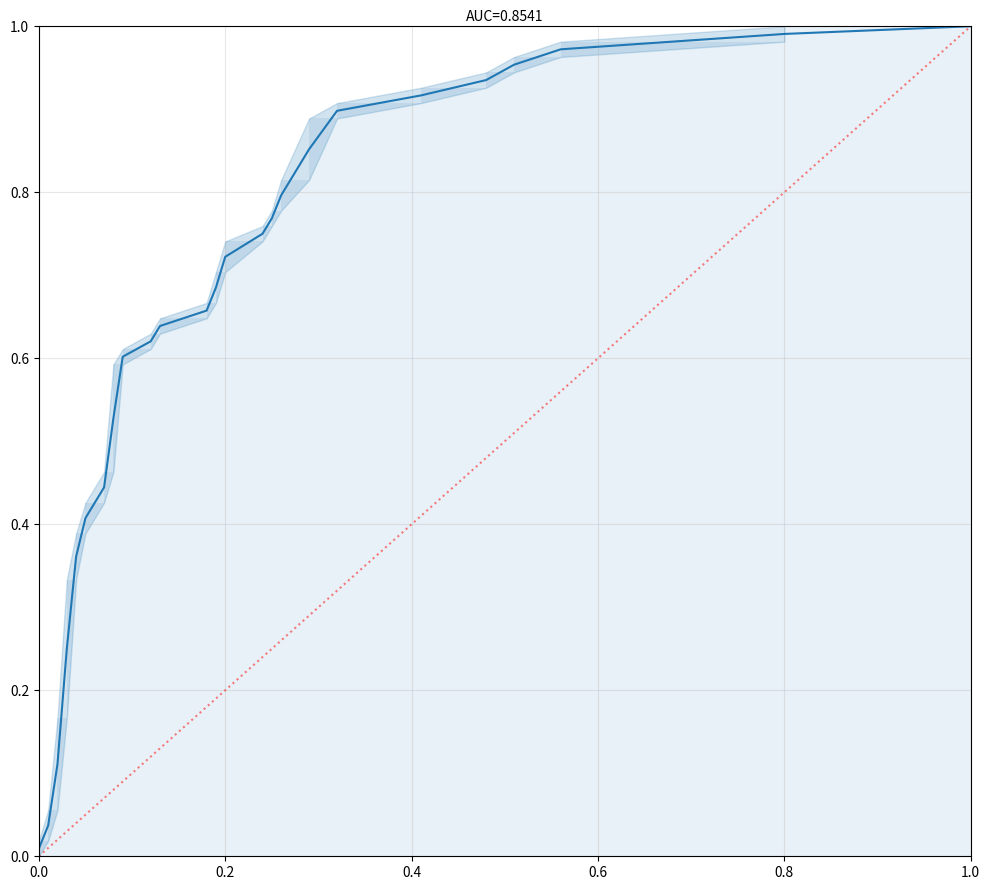

CPU times: user 842 ms, sys: 124 ms, total: 966 ms
Wall time: 431 ms


,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
LogisticRegression,0.766,0.629,0.815,0.260,0.740,0.710,0.854


In [9]:
%%time

logit_pipe = Pipeline([
    ("VIF_Selector", VIFSelector()),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(random_state=52))
])

logit_param_grid = {
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"],
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__max_iter": [100, 300, 500],
    "model__class_weight": [None, "balanced"],
}

logit_gs = GridSearchCV(
    estimator=logit_pipe,
    param_grid=logit_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

logit_gs.fit(x_train, y_train)

logit_estimator = logit_gs.best_estimator_

logit_score_df = hs_cls_bin_scores(logit_estimator, x_test, y_test)
logit_score_df

## #03. 경사하강법

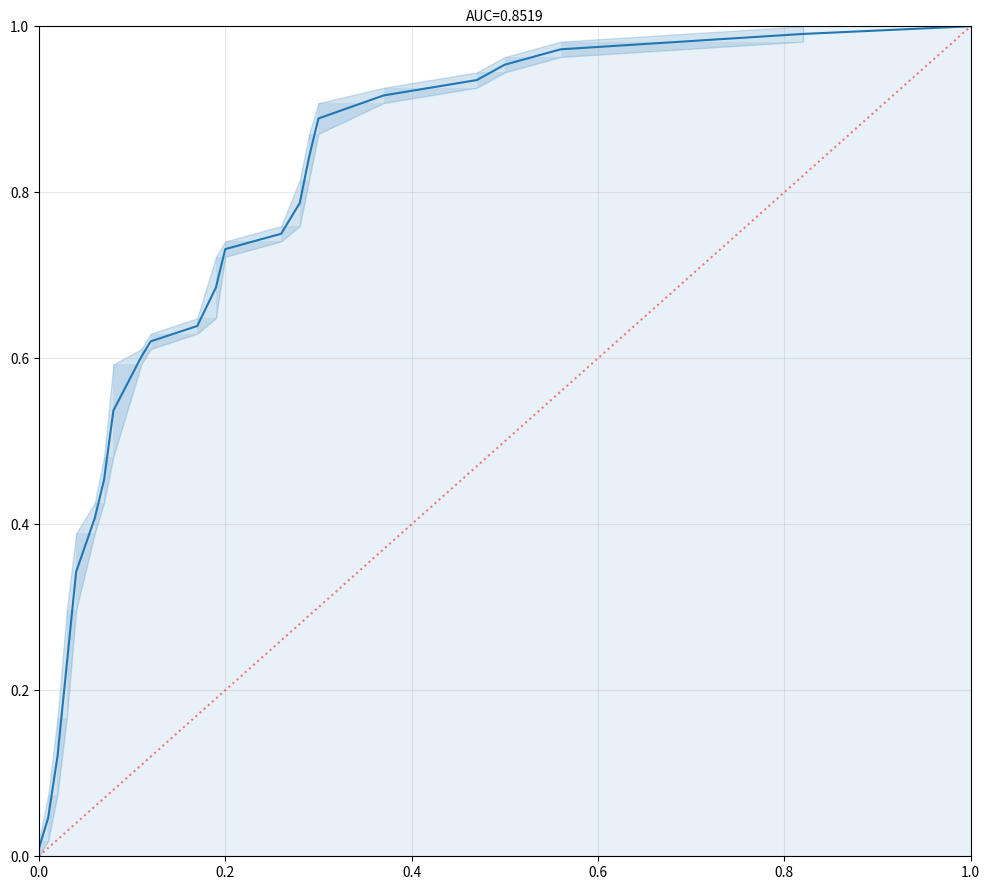

CPU times: user 1.1 s, sys: 797 ms, total: 1.89 s
Wall time: 1.35 s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
SGDClassifier,0.773,0.694,0.630,0.150,0.850,0.660,0.852


In [10]:
%%time

sgd_pipe = Pipeline([
    ("VIF_Selector", VIFSelector()),
    ("scaler", StandardScaler()),
    (
        "model",
        SGDClassifier(
            random_state=52,
            n_jobs=-1
        )
    ),
])

sgd_param_grid = {
    "model__loss": ["hinge", "log_loss", "modified_huber"],
    "model__penalty": ["l2", "l1", "elasticnet"],
    "model__alpha": [0.01, 0.1, 1, 10, 100], # C의 역수 대응
    "model__max_iter": [1000, 2000, 5000],
    "model__class_weight": [None, "balanced"],
}

sgd_gs = GridSearchCV(
    estimator=sgd_pipe,
    param_grid=sgd_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

sgd_gs.fit(x_train, y_train)

sgd_estimator = sgd_gs.best_estimator_

sgd_score_df = hs_cls_bin_scores(sgd_estimator, x_test, y_test)
sgd_score_df

## #04. KNN

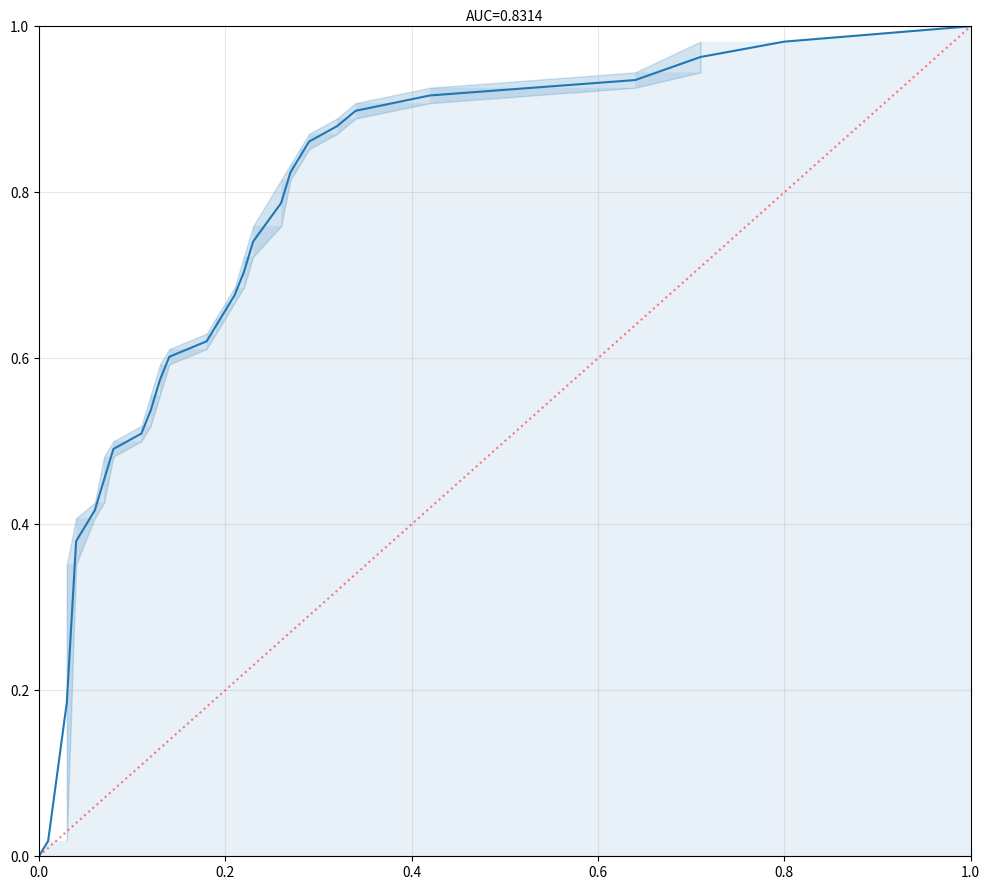

CPU times: user 766 ms, sys: 34.9 ms, total: 801 ms
Wall time: 829 ms


,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
KNeighborsClassifier,0.747,0.642,0.630,0.190,0.810,0.636,0.831


In [11]:
%%time

knn_cls_pipe = Pipeline([
    ("scaler", StandardScaler()), # 거리기반 → 필수
    (
        "model",
        KNeighborsClassifier(n_jobs=-1)
    ),
])

knn_cls_param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 15, 25],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan", "minkowski"],
    "model__p": [1, 2],
    "model__weights": ["uniform", "distance"],
}

knn_cls_gs = GridSearchCV(
    estimator=knn_cls_pipe,
    param_grid=knn_cls_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

knn_cls_gs.fit(x_train, y_train)

knn_cls_estimator = knn_cls_gs.best_estimator_

knn_cls_score_df = hs_cls_bin_scores(
    knn_cls_estimator,
    x_test,
    y_test
)
knn_cls_score_df

## #05. SVM

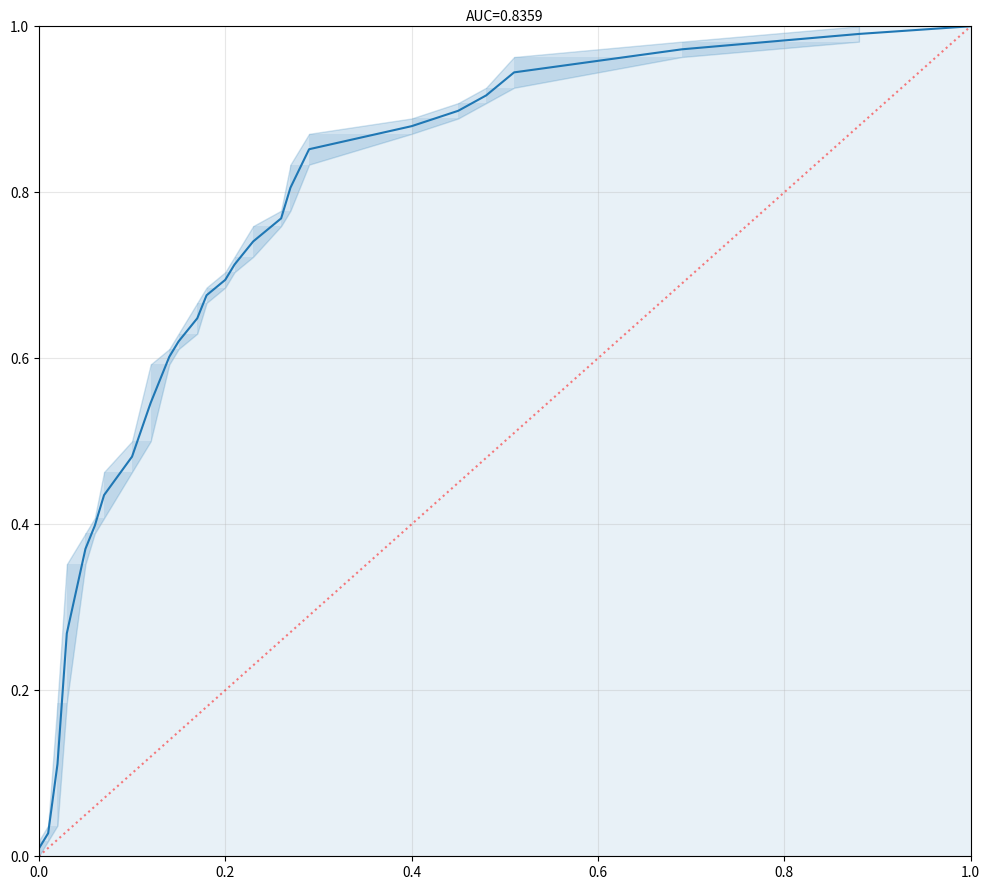

CPU times: user 780 ms, sys: 24.1 ms, total: 804 ms
Wall time: 2.18 s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
SVC,0.753,0.608,0.833,0.290,0.710,0.703,0.836


In [12]:
%%time

svc_pipe = Pipeline([
    ("scaler", StandardScaler()), # SVM 필수
    (
        "model",
        SVC(
            random_state=52,
            cache_size=200,
            probability=True, # 성능 평가를 위해 필수
        )
    ),
])

svc_param_grid = {
    "model__kernel": ["rbf"], # 수업·실습 기본은 rbf 고정
    "model__C": [0.1, 1, 10, 100],
    "model__gamma": ["scale", "auto", 0.01, 0.1, 1],
    "model__degree": [2, 3, 4], # kernel='poly'에서만 의미
    "model__class_weight": [None, "balanced"],
}

svc_gs = GridSearchCV(
    estimator=svc_pipe,
    param_grid=svc_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

svc_gs.fit(x_train, y_train)

svc_estimator = svc_gs.best_estimator_

svc_score_df = hs_cls_bin_scores(
    svc_estimator,
    x_test,
    y_test
)
svc_score_df

## #06. 랜덤 포레스트

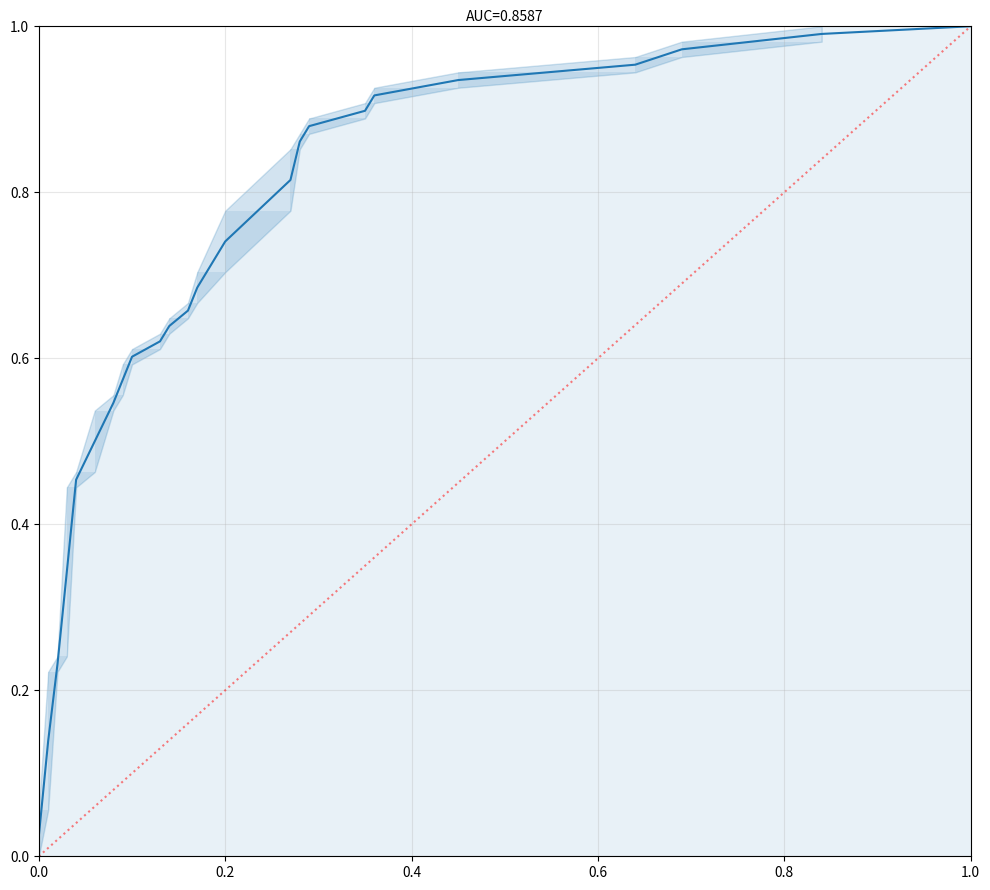

CPU times: user 1.25 s, sys: 162 ms, total: 1.41 s
Wall time: 17.2 s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
RandomForestClassifier,0.747,0.609,0.778,0.270,0.730,0.683,0.859


In [13]:
%%time

rf_cls_pipe = Pipeline([
    (
        "model",
        RandomForestClassifier(
            random_state=52,
            n_jobs=-1
        )
    ),
])

rf_cls_param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [None, 10],
    "model__min_samples_leaf": [5, 10],
    "model__max_features": ["sqrt", 1.0],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": [None, "balanced"],
}

rf_cls_gs = GridSearchCV(
    estimator=rf_cls_pipe,
    param_grid=rf_cls_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

rf_cls_gs.fit(x_train, y_train)

rf_cls_estimator = rf_cls_gs.best_estimator_

rf_cls_score_df = hs_cls_bin_scores(
    rf_cls_estimator,
    x_test,
    y_test
)
rf_cls_score_df

## #07. XGBoost

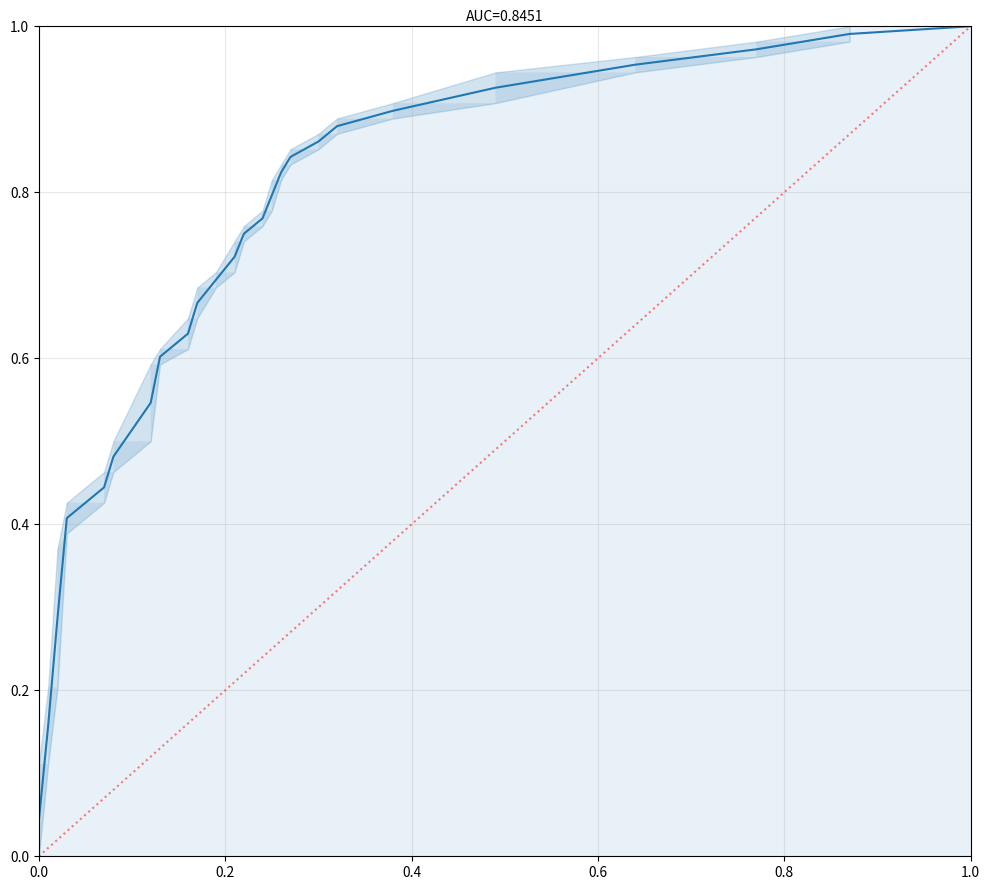

CPU times: user 9.13 s, sys: 723 ms, total: 9.85 s
Wall time: 1min 19s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
XGBClassifier,0.766,0.680,0.630,0.160,0.840,0.654,0.845


In [14]:
%%time

xgb_cls_pipe = Pipeline([
    (
        "model",
        XGBClassifier(
            objective="binary:logistic",
            random_state=52,
            n_jobs=-1
        )
    ),
])

xgb_cls_param_grid = {
    "model__n_estimators": [100, 300],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 5, 7],
    "model__min_child_weight": [1, 5, 10],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__reg_alpha": [0, 0.1, 1],
    "model__reg_lambda": [1, 5, 10],
    "model__scale_pos_weight": [1], # 불균형 시 조정
}

xgb_cls_gs = GridSearchCV(
    estimator=xgb_cls_pipe,
    param_grid=xgb_cls_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

xgb_cls_gs.fit(x_train, y_train)

xgb_cls_estimator = xgb_cls_gs.best_estimator_

xgb_cls_score_df = hs_cls_bin_scores(
    xgb_cls_estimator,
    x_test,
    y_test
)
xgb_cls_score_df

## #08. LightGBM

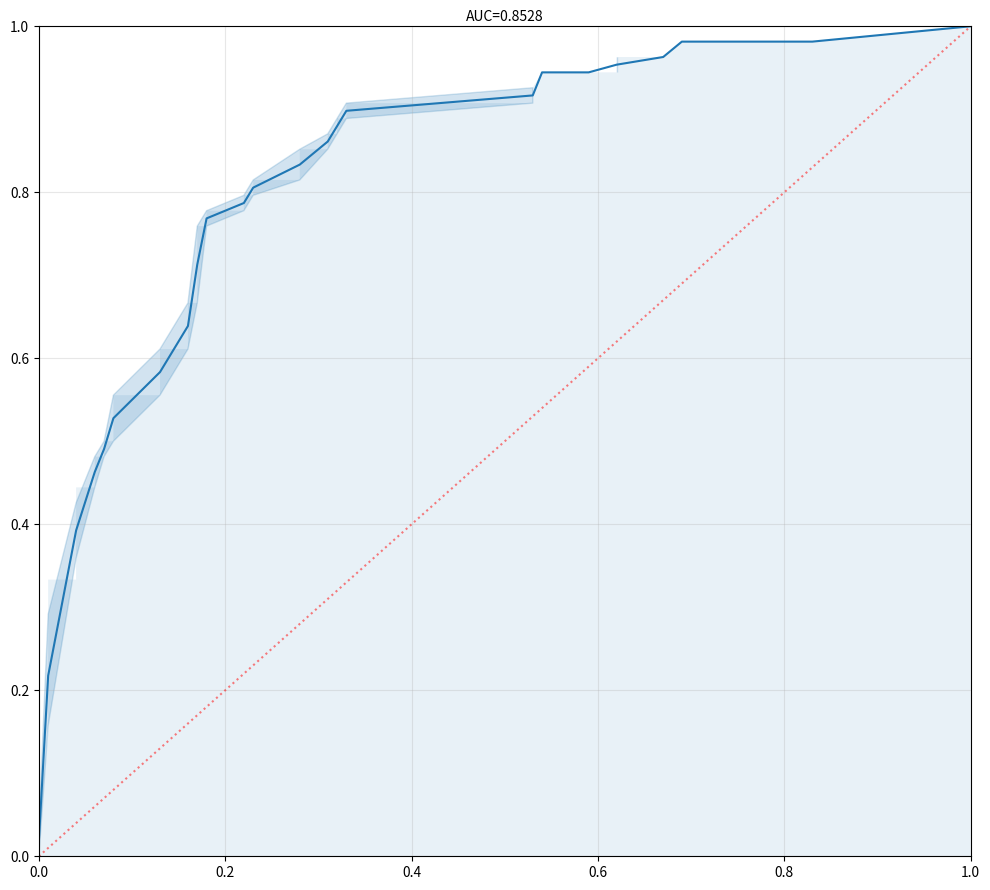

CPU times: user 713 ms, sys: 394 ms, total: 1.11 s
Wall time: 1min


,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
LGBMClassifier,0.766,0.705,0.574,0.130,0.870,0.633,0.853


In [15]:
%%time

lgbm_cls_pipe = Pipeline([
    (
        "model",
        LGBMClassifier(
            objective="binary",
            random_state=52,
            n_jobs=-1,
            verbose=-1
        )
    ),
])

lgbm_cls_param_grid = {
    "model__n_estimators": [100, 300],
    "model__learning_rate": [0.01, 0.05, 0.1],
    # "model__num_leaves": [15, 31],
    # "model__max_depth": [3, 5],
    # "model__min_child_samples": [10, 20],
    # "model__subsample": [0.6, 0.8, 1.0],
    "model__reg_alpha": [0, 0.1, 1],
    "model__reg_lambda": [0, 1, 5],
}

lgbm_cls_gs = GridSearchCV(
    estimator=lgbm_cls_pipe,
    param_grid=lgbm_cls_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

lgbm_cls_gs.fit(x_train, y_train)

lgbm_cls_estimator = lgbm_cls_gs.best_estimator_

lgbm_cls_score_df = hs_cls_bin_scores(
    lgbm_cls_estimator,
    x_test,
    y_test
)
lgbm_cls_score_df

## #09. CatBoost

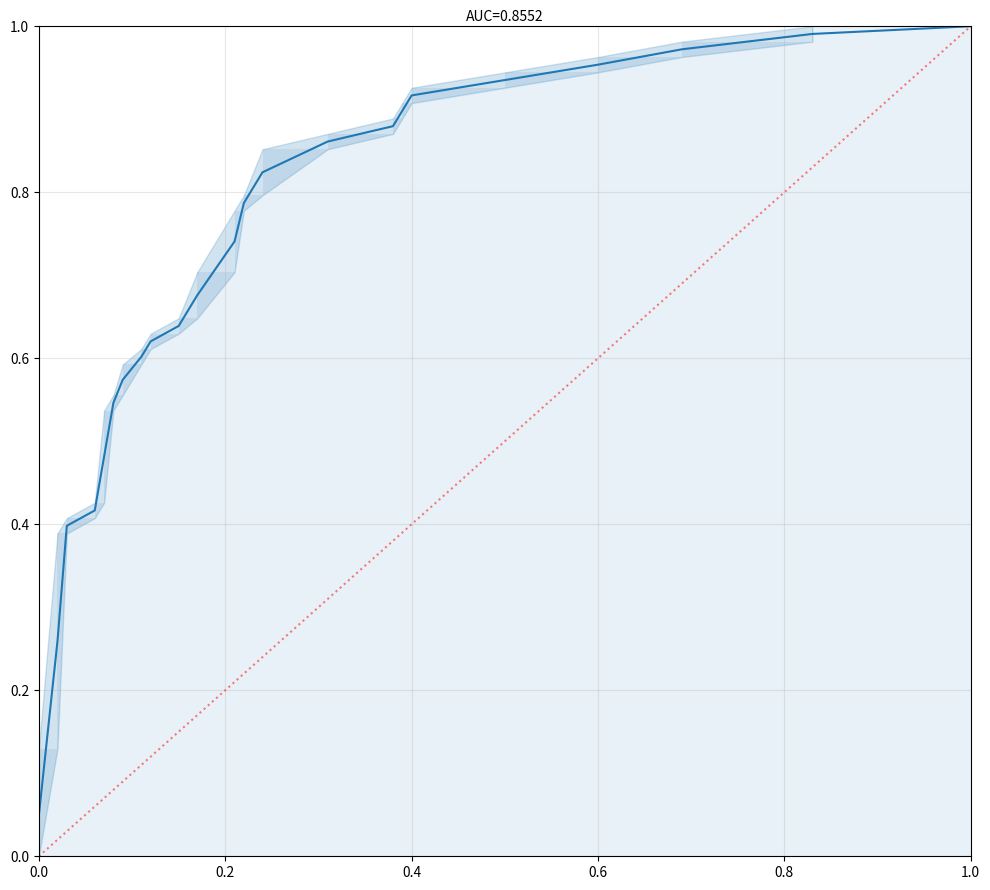

CPU times: user 1.47 s, sys: 198 ms, total: 1.66 s
Wall time: 13.3 s


,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
CatBoostClassifier,0.786,0.733,0.611,0.120,0.880,0.667,0.855


In [16]:
%%time

cat_cls_pipe = Pipeline([
    (
        "model",
        CatBoostClassifier(
            loss_function="Logloss",
            eval_metric="AUC",
            cat_features=[], # 범주형 변수 컬럼명 또는 인덱스 지정
            random_state=52,
            thread_count=-1,
            verbose=0
        )
    ),
])

cat_cls_param_grid = [
    { # Bayesian → subsample 제거
        "model__bootstrap_type": ["Bayesian"],
        "model__iterations": [300, 500],
        "model__learning_rate": [0.01, 0.03],
        "model__depth": [4, 6],
        "model__l2_leaf_reg": [1, 3],
        "model__rsm": [0.6, 1.0],
    },
    { # Bernoulli → subsample 허용
        "model__bootstrap_type": ["Bernoulli"],
        "model__iterations": [300, 500],
        "model__learning_rate": [0.01, 0.03],
        "model__depth": [4, 6],
        "model__l2_leaf_reg": [1, 3],
        "model__subsample": [0.6, 1.0],
        "model__rsm": [0.6, 1.0],
    },
]

cat_cls_gs = GridSearchCV(
    estimator=cat_cls_pipe,
    param_grid=cat_cls_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

cat_cls_gs.fit(
    x_train,
    y_train
)

cat_cls_estimator = cat_cls_gs.best_estimator_

cat_cls_score_df = hs_cls_bin_scores(
    cat_cls_estimator,
    x_test,
    y_test
)
cat_cls_score_df

## #10. 결과 정리

In [17]:
result_df = concat(
    [
        logit_score_df,
        sgd_score_df,
        knn_cls_score_df,
        svc_score_df,
        rf_cls_score_df,
        xgb_cls_score_df,
        lgbm_cls_score_df,
        cat_cls_score_df,
    ]
)

result_df.sort_values("AUC", ascending=False, inplace=True)
result_df

,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
RandomForestClassifier,0.747,0.609,0.778,0.270,0.730,0.683,0.859
CatBoostClassifier,0.786,0.733,0.611,0.120,0.880,0.667,0.855
LogisticRegression,0.766,0.629,0.815,0.260,0.740,0.710,0.854
LGBMClassifier,0.766,0.705,0.574,0.130,0.870,0.633,0.853
SGDClassifier,0.773,0.694,0.630,0.150,0.850,0.660,0.852
XGBClassifier,0.766,0.680,0.630,0.160,0.840,0.654,0.845
SVC,0.753,0.608,0.833,0.290,0.710,0.703,0.836
KNeighborsClassifier,0.747,0.642,0.630,0.190,0.810,0.636,0.831


### AUC를 우선으로 고려해야 하는 경우

**누가 더 위험한지 순위를 매기는 문제**

- 임계값이 아직 정해지지 않은 문제
  - 신용 위험 점수 모델
  - 질병 위험 예측
  - 고객 이탈 확률 예측

- 클래스 불균형이 큰 문제
  - 사기 탐지 (0.1%)
  - 고장 탐지

- 비용이 상황에 따라 변하는 문제
  - 마케팅 캠페인 타겟 선정
  - 보험 리스크 평가

### Recall을 우선 고려해야 하는 경우

**놓치면 안 되는 대상을 반드시 찾아내야 하는 문제**

(FN, False Negative 비용이 매우 큰 상황)

- 생명·안전과 직결되는 문제
  - 암 진단
  - 중증 질환 조기 발견
  - 감염병 선별 검사

- 재난·사고 예방 문제
  - 산업 설비 고장 탐지
  - 화재·가스 누출 탐지
  - 자율주행 보행자 인식

- 보안·위험 탐지 문제
  - 침입 탐지 시스템
  - 이상 거래 탐지 (사후 차단 가능할 때)
  - 테러·위험 물질 탐지

- 1차 스크리닝 단계 문제
  - 건강검진 선별 모델
  - 대출 심사 1차 위험군 분류
  - 보험 리스크 1차 분류

In [18]:
result_df.sort_values("재현율(Recall,tpr)", ascending=False)

,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
SVC,0.753,0.608,0.833,0.290,0.710,0.703,0.836
LogisticRegression,0.766,0.629,0.815,0.260,0.740,0.710,0.854
RandomForestClassifier,0.747,0.609,0.778,0.270,0.730,0.683,0.859
SGDClassifier,0.773,0.694,0.630,0.150,0.850,0.660,0.852
XGBClassifier,0.766,0.680,0.630,0.160,0.840,0.654,0.845
KNeighborsClassifier,0.747,0.642,0.630,0.190,0.810,0.636,0.831
CatBoostClassifier,0.786,0.733,0.611,0.120,0.880,0.667,0.855
LGBMClassifier,0.766,0.705,0.574,0.130,0.870,0.633,0.853


### Accuracy(정확도)를 우선 고려해야 하는 경우

**양성과 음성의 비율이 균형에 가깝고, 오분류 비용이 유사한 문제**

- 일반적인 다중분류 문제
  - 이미지 분류
  - 문서 주제 분류
  - 제품 카테고리 분류

- 오분류 비용이 거의 동일한 문제
  - 간단한 품질 등급 분류
  - 고객 세그먼트 분류

- 불균형이 크지 않은 데이터셋
  - 클래스 비율이 40:60 수준

**핵심 기준:**

"틀리는 것이 크게 위험하지 않고, 전체적으로 얼마나 맞추는가가 중요한가?"

### Precision(정밀도)를 우선 고려해야 하는 경우

**양성으로 예측한 것의 신뢰도가 중요한 문제**

(FP, False Positive 비용이 큰 상황)

- 의료 진단 확정 단계
  - 고위험 수술 대상 판정
  - 강한 부작용 치료 적용 대상 선정

- 법적·재정적 책임이 큰 문제
  - 보험 사기 확정 판정
  - 범죄 혐의 분류

- 마케팅 비용이 높은 타겟팅
  - 고가 상품 캠페인
  - VIP 전용 프로모션

**핵심 기준:**

"양성이라고 판단했는데 실제로 음성이면 큰 비용이 발생하는가?"

### Fallout (FPR, 위양성율)를 우선 고려해야 하는 경우

**정상 집단을 잘못 양성으로 분류하면 큰 손실이 발생하는 문제**

- 정상 고객 차단 위험
  - 카드 결제 차단
  - 계정 정지 시스템

- 정상 환자 오진
  - 불필요한 검사·치료

- 서비스 품질 유지 문제
  - 정상 사용자의 이용 제한

### Specificity (특이성, TNR)를 우선 고려해야 하는 경우

**정상(음성)을 정확히 유지하는 것이 중요한 문제**

- 대규모 스크리닝 검사
  - 정상자를 최대한 정상으로 유지

- 자동 승인 시스템
  - 정상 대출 승인

- 고객 유지 전략
  - 정상 고객을 이탈 위험군으로 오분류 방지

### F1 Score를 우선 고려해야 하는 경우

**Precision과 Recall을 동시에 고려해야 하는 불균형 문제**

- 사기 탐지
- 의료 진단 중간 단계
- 이상 탐지 모델 평가